## Dataset Merge (Multi/Mono)

- group_info: `group_config.yaml`

In [1]:
!uv pip install torchmetrics segmentation-models-pytorch -q

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import os
import sys
sys.path.append('..')

import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import warnings
from torch.utils.data import DataLoader
from pathlib import Path
warnings.filterwarnings("ignore")

try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

# 환경에 따라 PROJECT_ROOT 설정
if IN_COLAB:
    PROJECT_ROOT = '/content/drive/Othercomputers/내 Mac/Road_Lane_segmentation'
else:
    PROJECT_ROOT = Path.cwd().parents[0]
SEED = 42

# sys.path 추가 (import용)
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

# 작업 디렉토리 변경 (파일 접근용)
os.chdir(PROJECT_ROOT)

print(f"Environment: {'Colab' if IN_COLAB else 'Local'}")
print(f"PROJECT_ROOT: {PROJECT_ROOT}")
print(f"Current working directory: {os.getcwd()}")

from src.utils import setup_workspace, load_config, get_device, seed
from src.data import DatasetLoader, get_transforms, split_dataset
from src.models.losses import get_loss
from src.inference import Inferencer, visualize_prediction, visualize_comparison

Environment: Local
PROJECT_ROOT: /Users/mungughyeon/내 드라이브/likelion/Road_Lane_segmentation
Current working directory: /Users/mungughyeon/내 드라이브/likelion/Road_Lane_segmentation


In [2]:
setup_workspace(PROJECT_ROOT)
# seed(SEED)
get_device()

MAIN_CONFIG_ROOT = "configs/config.yaml"
GROUP_CONFIG_ROOT = "configs/group_config.yaml"

config = load_config(MAIN_CONFIG_ROOT)
group_config = load_config(GROUP_CONFIG_ROOT)
config

Env: Local | Root: /Users/mungughyeon/내 드라이브/likelion/Road_Lane_segmentation
Device: mps


{'data': {'root': 'dataset/Multi_Camera_Semantic_Segmentation',
  'additional_roots': ['dataset/Mono_Camera_Semantic_Segmentation'],
  'class_info': 'dataset/total_class_info.csv',
  'img_size': [768, 576],
  'group_config': 'configs/group_config.yaml',
  'augmentation_enabled': True,
  'augmentation_config': 'configs/augmentation.yaml'},
 'model': {'name': 'UnetPlusPlus',
  'encoder': 'efficientnet-b4',
  'pretrained': True},
 'training': {'train_batch_size': 24,
  'eval_batch_size': 32,
  'accumulation_steps': 3,
  'epochs': 100,
  'lr': 0.0006,
  'weight_decay': 0.0002,
  'dropout': 0.2,
  'early_stop': 7,
  'num_workers': 8,
  'scheduler': {'enabled': True, 'type': 'cosine', 'min_lr': 5e-06}},
 'checkpoint': {'dir': 'checkpoints', 'exp_name': 'Merge_Data'},
 'loss': {'type': 'focal+dice',
  'weights': {'focal': 0.5, 'dice': 0.5},
  'ignore_index': 255,
  'focal_gamma': 2.0,
  'class_weights': {'enabled': True,
   'method': 'inverse',
   'beta': 0.999,
   'normalize': True,
   'manu

### Train

In [ ]:
from src.training import Trainer

trainer = Trainer(config_path=MAIN_CONFIG_ROOT)
trainer.train()

### Eval

In [ ]:
from src.evaluation import Evaluator

checkpoint_path = "checkpoints/UnetPlusPlus_efficientnet-b4_Merge_Data/best.pt"
evaluator = Evaluator(config_path=MAIN_CONFIG_ROOT, checkpoint_path=checkpoint_path)
evaluator.train_cfg["eval_batch_size"] = 4
evaluator.setup_data() # 재생성

metrics = evaluator.evaluate()
metrics

In [4]:
import numpy as np

def create_colormap(num_classes):
    colormap = np.random.randint(0, 255, size=(num_classes, 3), dtype=np.uint8)
    colormap[0] = [0, 0, 0]  # background는 검정
    return colormap

def mask_to_color(mask, colormap):
    h, w = mask.shape
    color_mask = np.zeros((h, w, 3), dtype=np.uint8)
    for class_id, color in enumerate(colormap):
        color_mask[mask == class_id] = color
    return color_mask

In [5]:
import random

MEAN = [0.485, 0.456, 0.406]
STD  = [0.229, 0.224, 0.225]

def visualize_segmentation(
    model,
    dataloader,
    device,
    num_classes,
    num_samples=3,
    alpha=0.5
):
    model.eval()
    colormap = create_colormap(num_classes)

    loader_iter = iter(dataloader)
    rand_step = random.randint(0, len(dataloader) - 1)

    for _ in range(rand_step):
        images, masks = next(loader_iter)

    with torch.no_grad():
        images, masks = next(loader_iter)

        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)["out"]
        preds = outputs.argmax(dim=1)

        images = images.cpu()
        masks = masks.cpu()
        preds = preds.cpu()

        idxs = random.sample(
            range(images.size(0)),
            k=min(num_samples, images.size(0))
        )

        for i in idxs:
            img = images[i].clone()

            for c in range(3):
                img[c] = img[c] * STD[c] + MEAN[c]

            img_np = img.permute(1, 2, 0).numpy()
            img_np = np.clip(img_np, 0, 1)

            gt_mask = masks[i].numpy()
            pred_mask = preds[i].numpy()

            gt_color = mask_to_color(gt_mask, colormap)
            pred_color = mask_to_color(pred_mask, colormap)

            overlay = img_np * (1 - alpha) + (pred_color / 255.0) * alpha

            fig, axes = plt.subplots(1, 4, figsize=(24, 6))

            axes[0].imshow(img_np)
            axes[0].set_title("Image")

            axes[1].imshow(gt_color)
            axes[1].set_title("GT Mask")

            axes[2].imshow(pred_color)
            axes[2].set_title("Pred Mask")

            axes[3].imshow(overlay)
            axes[3].set_title("Overlay")

            for ax in axes:
                ax.axis("off")

            plt.tight_layout()
            plt.show()

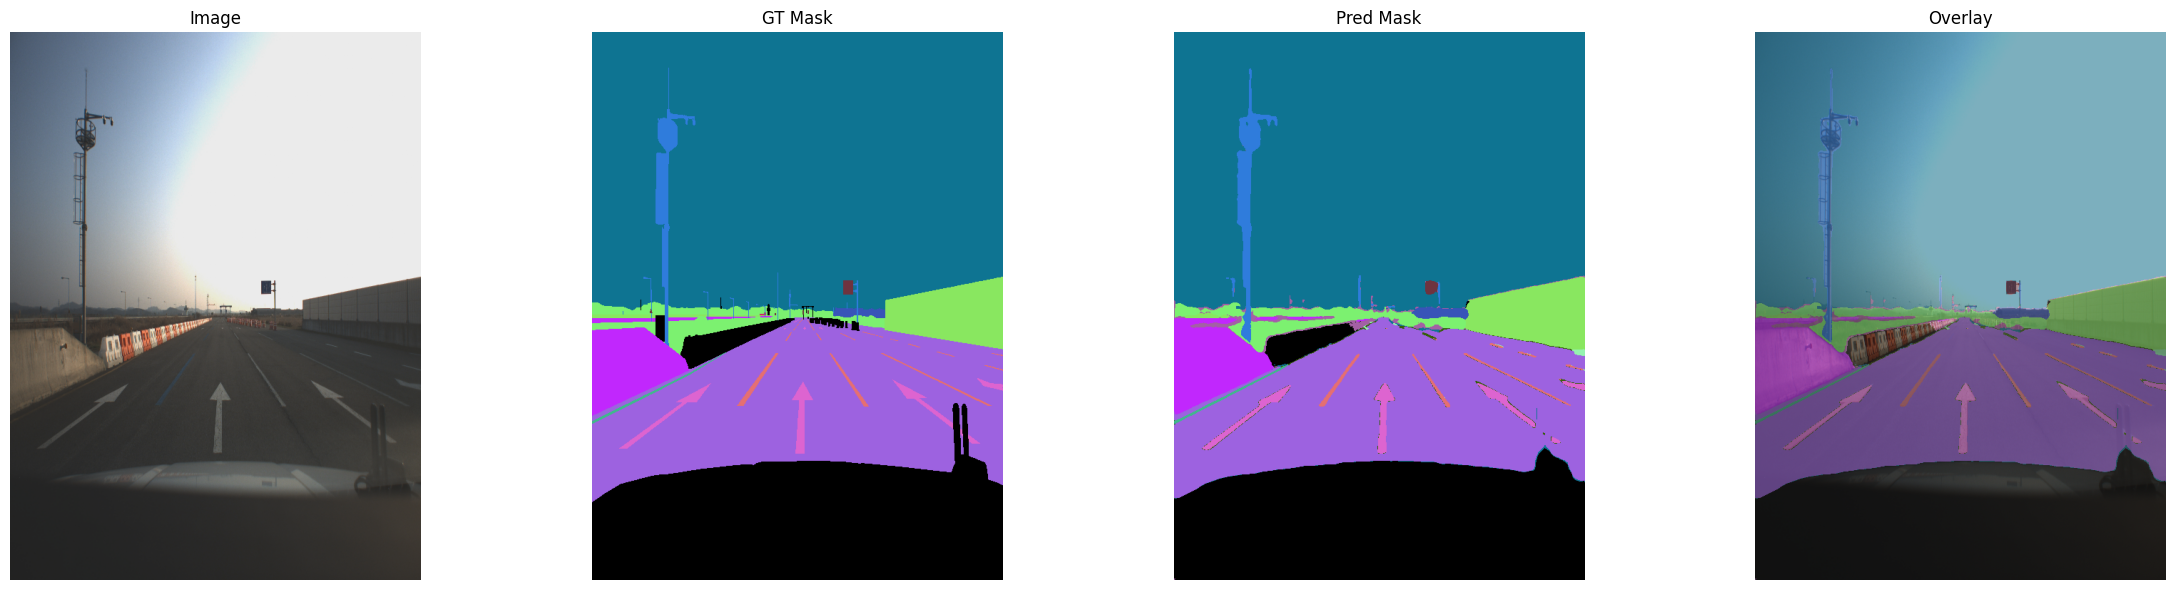

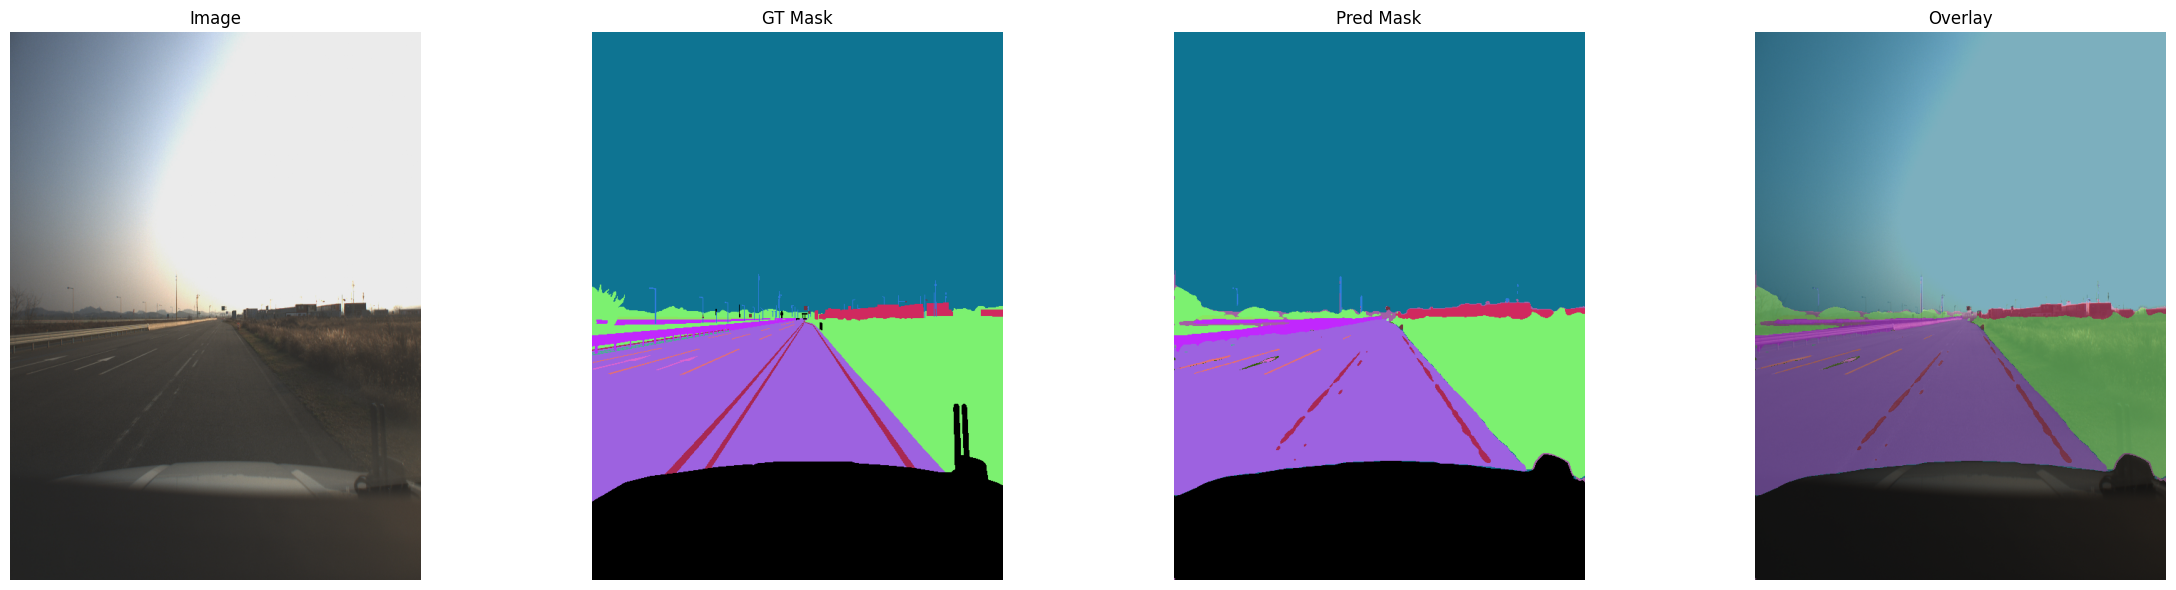

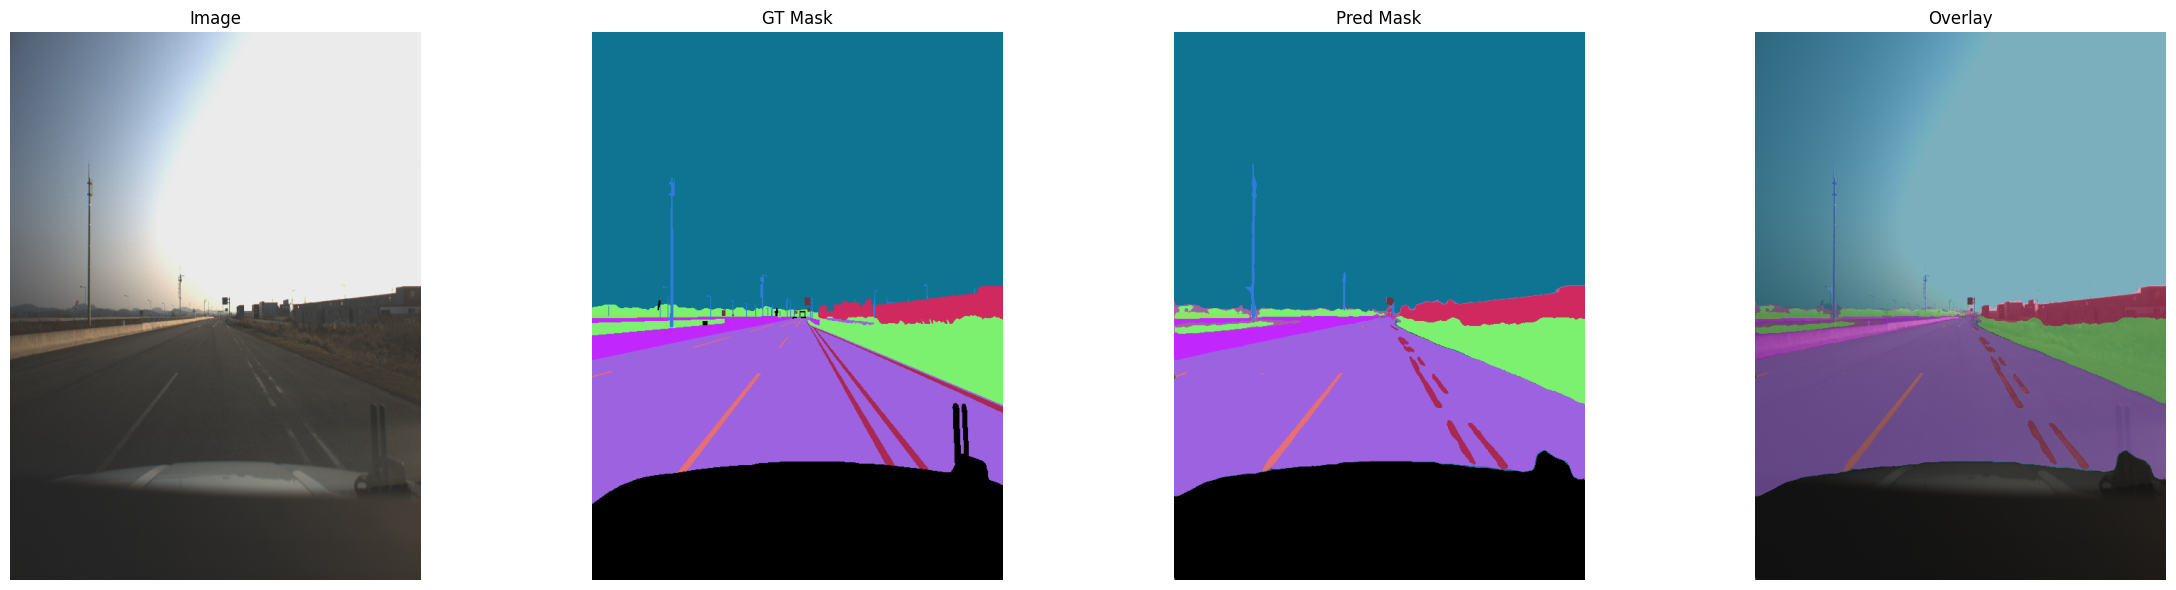

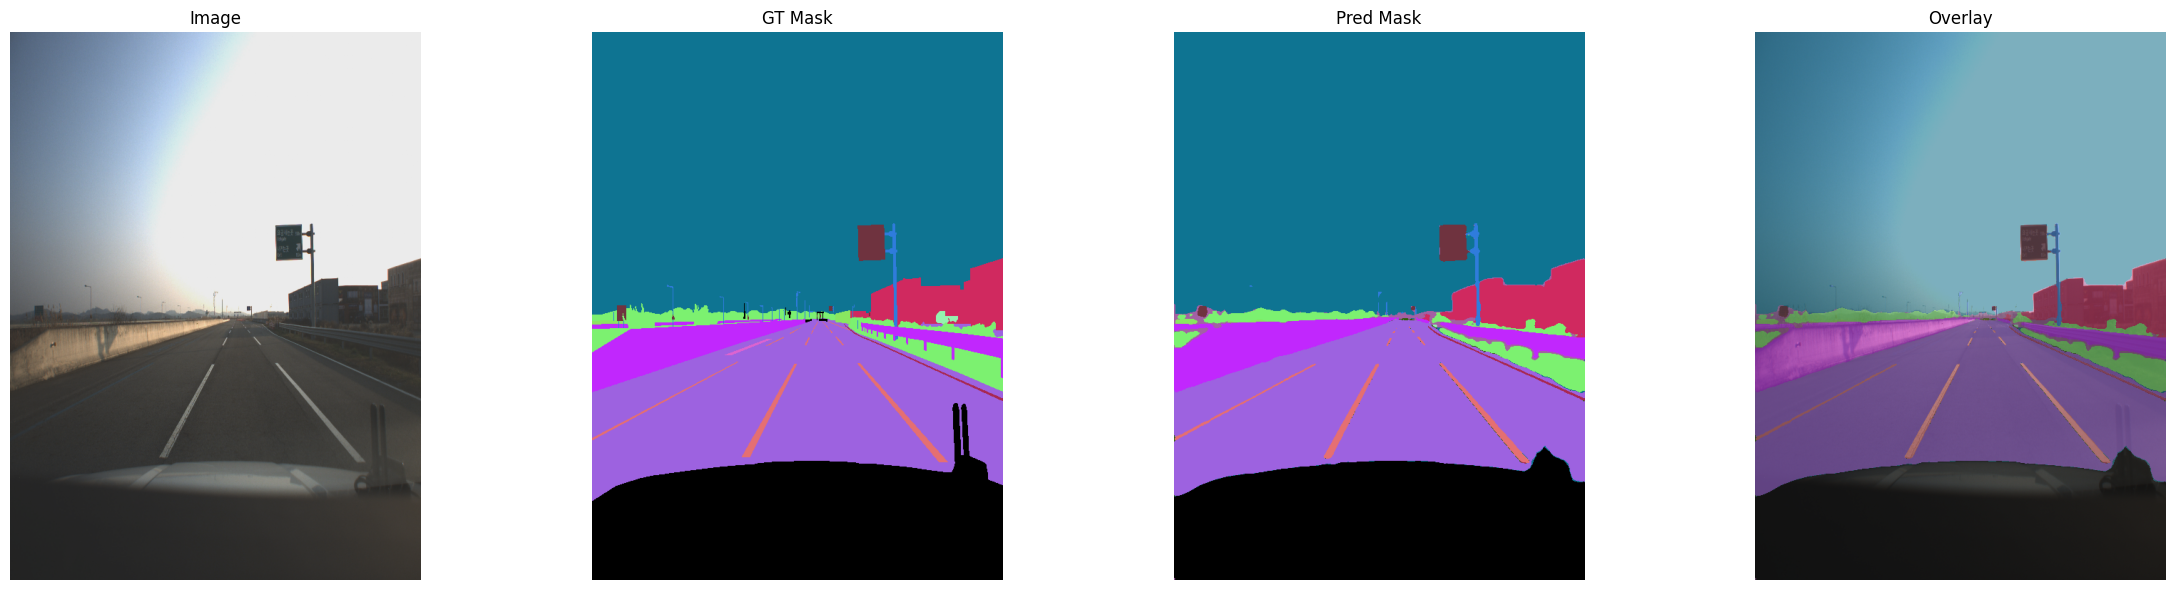

In [9]:
visualize_segmentation(
    model=evaluator.model,
    dataloader=evaluator.dataloader,
    device=evaluator.device,
    num_classes=evaluator.num_classes,
    num_samples=5
)

In [7]:
from sklearn.metrics import confusion_matrix

def compute_confusion_matrix(
    model,
    dataloader,
    device,
    num_classes,
    ignore_index=255
):
    model.eval()

    all_preds = []
    all_targets = []

    with torch.no_grad():
        for images, masks in dataloader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)["out"]
            preds = outputs.argmax(dim=1)

            preds = preds.view(-1).cpu().numpy()
            targets = masks.view(-1).cpu().numpy()

            valid_mask = targets != ignore_index
            preds = preds[valid_mask]
            targets = targets[valid_mask]

            all_preds.append(preds)
            all_targets.append(targets)

    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)

    cm = confusion_matrix(
        all_targets,
        all_preds,
        labels=list(range(num_classes))
    )

    return cm

def plot_confusion_matrix(
    cm,
    class_names=None,
    normalize=True,
    figsize=(8, 6)
):
    if normalize:
        cm = cm.astype(np.float32)
        cm = cm / (cm.sum(axis=1, keepdims=True) + 1e-6)

    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation="nearest", cmap="Blues")
    plt.colorbar()

    if class_names is not None:
        plt.xticks(range(len(class_names)), class_names, rotation=90)
        plt.yticks(range(len(class_names)), class_names)

    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

In [8]:
def plot_grouped_confusion_matrix(cm, selected_ids=None, selected_names=None, normalize=True):
    """그룹화된 confusion matrix 시각화"""

    if selected_ids is None:
        # 전체 15개 그룹
        selected_ids = list(range(15))
        selected_names = [GROUP_NAMES[i] for i in selected_ids]

    specific_cm = cm[np.ix_(selected_ids, selected_ids)]

    if normalize:
        specific_cm = specific_cm.astype('float') / (specific_cm.sum(axis=1, keepdims=True) + 1e-7)
        title = "Normalized Grouped Confusion Matrix"
        fmt = '.2f'
    else:
        title = "Grouped Confusion Matrix (Pixel Counts)"
        fmt = 'd'

    plt.figure(figsize=(10, 8))
    plt.imshow(specific_cm, interpolation='nearest', cmap='Blues')
    plt.title(title, fontsize=15)
    plt.colorbar()

    tick_marks = np.arange(len(selected_names))
    plt.xticks(tick_marks, selected_names, rotation=45, ha='right')
    plt.yticks(tick_marks, selected_names)

    thresh = specific_cm.max() / 2.
    for i, j in np.ndindex(specific_cm.shape):
        plt.text(j, i, format(specific_cm[i, j], fmt),
                  ha="center", va="center",
                  color="white" if specific_cm[i, j] > thresh else "black",
                  fontsize=9)

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()


import platform
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
import os

def setup_korean_font():
    """Colab/Mac/Windows 한글 폰트 설정"""
    system = platform.system()

    try:
        import google.colab
        IN_COLAB = True
    except ImportError:
        IN_COLAB = False

    if IN_COLAB:
        # Colab: 나눔고딕 설치
        os.system('apt-get -qq install fonts-nanum > /dev/null 2>&1')
        font_manager.fontManager.addfont('/usr/share/fonts/truetype/nanum/NanumGothic.ttf')
        rc('font', family='NanumGothic')
        print('Hangul OK in Colab!')

    elif system == 'Darwin':  # Mac
        rc('font', family='Arial Unicode MS')
        print('Hangul OK in Mac!')

    elif system == 'Windows':
        rc('font', family='Malgun Gothic')
        print('Hangul OK in Windows!')

    else:
        print('Unknown system.. sorry')

    plt.rcParams['axes.unicode_minus'] = False

# 실행
setup_korean_font()

Hangul OK in Mac!


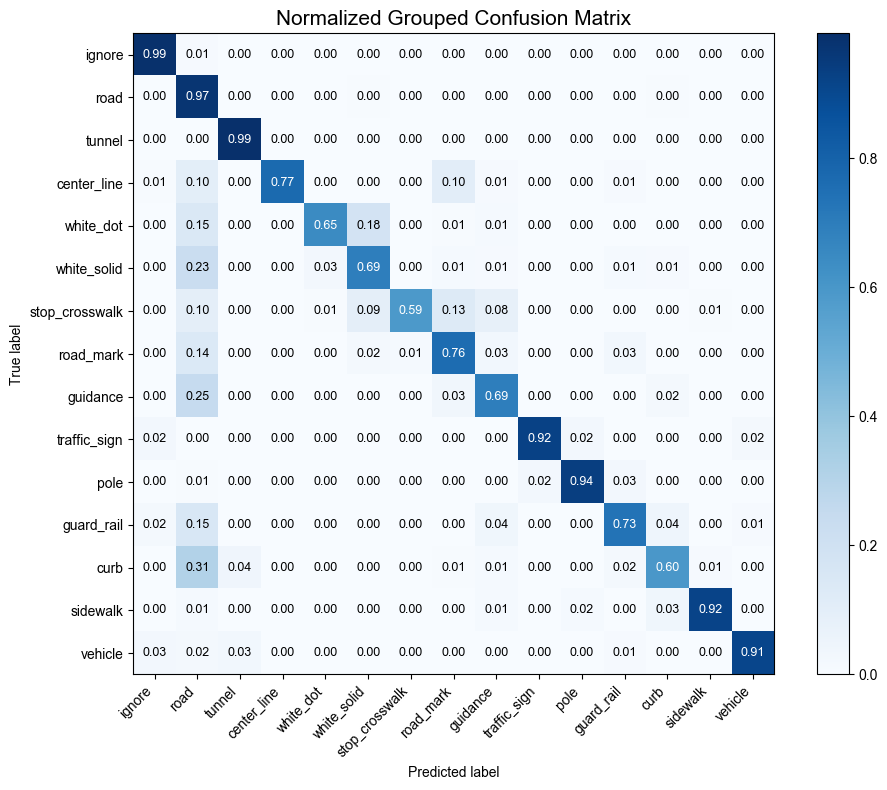

In [9]:
# 모든 그룹 ID (
GROUP_NAMES = group_config["group_names"]
all_group_ids = list(range(20))
all_group_names = [GROUP_NAMES[i] for i in all_group_ids]

# 전체 Confusion Matrix
cm = compute_confusion_matrix(
    model=evaluator.model,
    dataloader=evaluator.dataloader,
    device=evaluator.device,
    num_classes=20,
    ignore_index=255
)

plot_grouped_confusion_matrix(cm)